<a href="https://colab.research.google.com/github/iamnelsonizah/Computer-Vision-Projects-with-Python/blob/main/groundwater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
!pip install tensorflow

<ipython-input-7-1624f00ce5b1>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').dropna()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.1149 - val_loss: 0.0493
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0495 - val_loss: 0.0325
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0383 - val_loss: 0.0247
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0297 - val_loss: 0.0177
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0206 - val_loss: 0.0092
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0109 - val_loss: 0.0095
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0071 - val_loss: 0.0080
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0

LSTM Model - MAE: 0.0598, RMSE: 0.0772, R²: 0.8502
Random Forest - MAE: 0.0388, RMSE: 0.0492, R²: 0.9392
SVR Model - MAE: 0.0765, RMSE: 0.0886, R²: 0.8024
Gradient Boosting - MAE: 0.0312, RMSE: 0.0408, R²: 0.9580


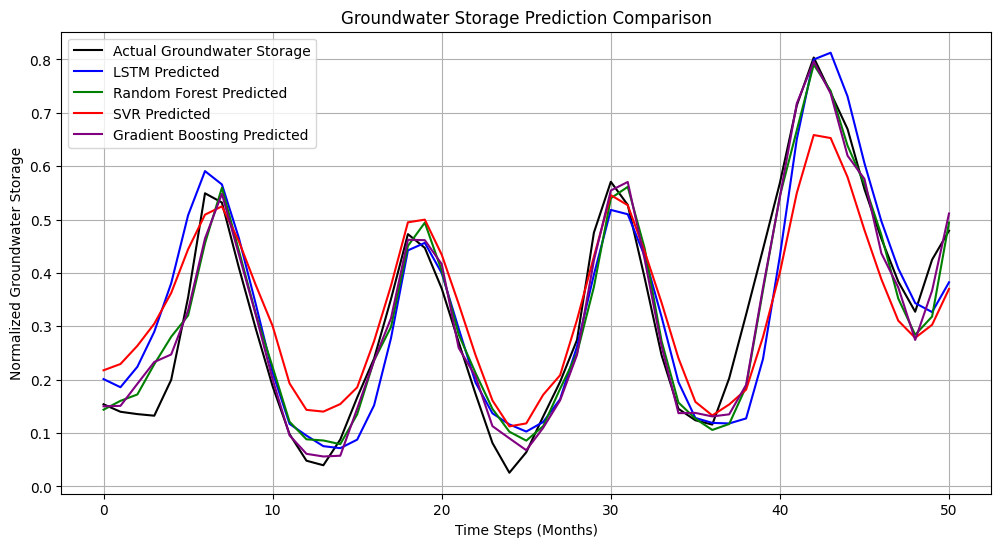

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Load and clean the data
# -----------------------------

df = pd.read_csv('/content/sample_data/ML_Feature_Table_Kazakhstan.csv')

# Parse date column and set as index
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df = df.set_index('date').sort_index()

# Select and rename relevant columns
df = df[['rainfall', 'snowfall', 'soil_moisture', 'temperature', 'groundwater']]
df.rename(columns={
    'groundwater': 'groundwater_storage'
}, inplace=True)

# Handle missing values
df = df.fillna(method='ffill').dropna()

# -----------------------------
# Step 2: Normalize the data
# -----------------------------
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# -----------------------------
# Step 3: Create sequences for LSTM
# -----------------------------
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, -1])  # target: groundwater_storage
    return np.array(X), np.array(y)

seq_length = 12  # 12 months history
X, y = create_sequences(data_scaled, seq_length)

# -----------------------------
# Step 4: Train-test split
# -----------------------------
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -----------------------------
# Step 5: Build LSTM model
# -----------------------------
def build_lstm_model():
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, X.shape[2])),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = build_lstm_model()

# -----------------------------
# Step 6: Train LSTM model
# -----------------------------
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# -----------------------------
# Step 7: Predictions using LSTM
# -----------------------------
lstm_predictions = lstm_model.predict(X_test, verbose=0)

# -----------------------------
# Step 8: Other ML Models
# -----------------------------

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Flatten for RF
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# Support Vector Regression (SVR)
svr_model = SVR()
svr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Flatten for SVR
svr_predictions = svr_model.predict(X_test.reshape(X_test.shape[0], -1))

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Flatten for GB
gb_predictions = gb_model.predict(X_test.reshape(X_test.shape[0], -1))

# -----------------------------
# Step 9: Calculate Metrics (MAE, RMSE, R²) for All Models
# -----------------------------

def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return mae, rmse, r2

# LSTM Model Metrics
lstm_mae, lstm_rmse, lstm_r2 = evaluate_model(lstm_predictions, y_test)

# Random Forest Metrics
rf_mae, rf_rmse, rf_r2 = evaluate_model(rf_predictions, y_test)

# SVR Metrics
svr_mae, svr_rmse, svr_r2 = evaluate_model(svr_predictions, y_test)

# Gradient Boosting Metrics
gb_mae, gb_rmse, gb_r2 = evaluate_model(gb_predictions, y_test)

# -----------------------------
# Step 10: Print Results
# -----------------------------

print("LSTM Model - MAE: {:.4f}, RMSE: {:.4f}, R²: {:.4f}".format(lstm_mae, lstm_rmse, lstm_r2))
print("Random Forest - MAE: {:.4f}, RMSE: {:.4f}, R²: {:.4f}".format(rf_mae, rf_rmse, rf_r2))
print("SVR Model - MAE: {:.4f}, RMSE: {:.4f}, R²: {:.4f}".format(svr_mae, svr_rmse, svr_r2))
print("Gradient Boosting - MAE: {:.4f}, RMSE: {:.4f}, R²: {:.4f}".format(gb_mae, gb_rmse, gb_r2))

# -----------------------------
# Step 11: Plot Predictions for Visual Comparison
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label="Actual Groundwater Storage", color='black')
plt.plot(range(len(lstm_predictions)), lstm_predictions, label="LSTM Predicted", color='blue')
plt.plot(range(len(rf_predictions)), rf_predictions, label="Random Forest Predicted", color='green')
plt.plot(range(len(svr_predictions)), svr_predictions, label="SVR Predicted", color='red')
plt.plot(range(len(gb_predictions)), gb_predictions, label="Gradient Boosting Predicted", color='purple')
plt.legend()
plt.title("Groundwater Storage Prediction Comparison")
plt.xlabel("Time Steps (Months)")
plt.ylabel("Normalized Groundwater Storage")
plt.grid(True)
plt.show()
